# Boston Housing Linear Regression

### Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
# Score Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# 3D Visualization
from mpl_toolkits.mplot3d import Axes3D
# Widget
import ipywidgets as widgets
# Remove Outliers
from sklearn.neighbors import LocalOutlierFactor
# Feature Scaler
from sklearn.preprocessing import StandardScaler
#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

### Stylistics

In [2]:
%matplotlib inline
plt.style.use("dark_background")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 100)
pd.set_option("precision", 2)

### Import the Dataset

In [3]:
boston_dataset = load_boston()

boston is a bunch data type so we are presented with a dictionary like structure with keys mentioned below.


In [4]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

#### Data Definition

Let's look at the definition of these columns to better understand the data.

In [5]:
print(boston_dataset.DESCR[:1227])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Based on the Data Definition, we can see that we have 13 columns and the 14th one is the target variable which is the Median Value stored on  bonston_dataset.target.

Both features and target columns are separated so let's join the two columns into one DataFrame for later correlational analysis.

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,0.54,6.58,65.2,4.09,1.0,296.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.9,4.97,2.0,242.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.1,4.97,2.0,242.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.8,6.06,3.0,222.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,0.46,7.15,54.2,6.06,3.0,222.0,18.7,396.90,5.33


In [7]:
boston["MEDV"] = boston_dataset.target

### Data Cleaning

#### Remove NULL Values 

Let's look at if we have null values in our dataset to make sure.

In [8]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

#### Removing Outliers

In [9]:
# lof = LocalOutlierFactor()
# outlier_pred = lof.fit_predict(X_train)
# inliners = outlier_pred != -1
# X_train, y_train = X_train[inliners, :], y_train[inliners]

In [10]:
features = ["RM", "LSTAT", "MEDV"]
before_removal = boston.shape[0]
for feature in features:
    
    feature_mean = boston[feature].mean()
    cut_off = 3 * boston[feature].std()
    
    min_ = feature_mean - cut_off
    max_ = feature_mean + cut_off
    
    boston = boston[boston[feature] >= min_]
    boston = boston[boston[feature] <= max_]
    print("Number of Remaining Observations: {} -> {}".format(feature, boston[feature].shape[0]))

print("\nNumber of Identified Outliers: {}".format(before_removal - boston.shape[0]))

Number of Remaining Observations: RM -> 498
Number of Remaining Observations: LSTAT -> 493
Number of Remaining Observations: MEDV -> 479

Number of Identified Outliers: 27


Now we are sure that every column in our dataset has no null values.

### Feature Engineering

Let's first check the correlation of each columns in our dataset.

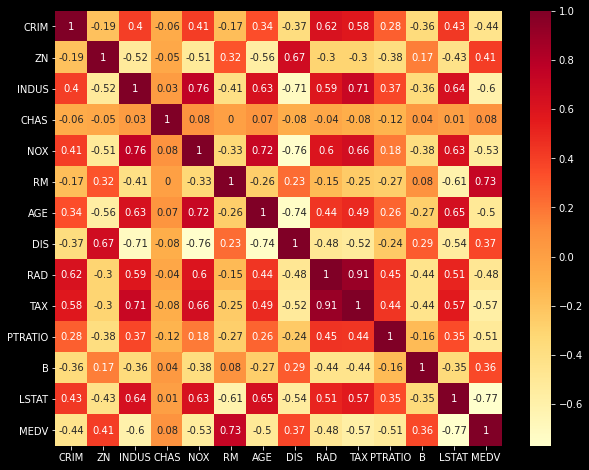

In [11]:
ax, figure = plt.subplots(figsize=(10, 8))
correlation_matrix = boston.corr().round(2)
_ = sns.heatmap(correlation_matrix, annot=True, cmap="YlOrRd")
plt.savefig("heatmap.png")

The higher the intensity of the color is, the more it is correlated to the corresponding column. It means if the value is close to 1, the more they are positively correlated and the closer it is to -1 the more they are negatively correlated.

The goal here is to find the most highly correlated columns into the target feature `MEDV` and use it in linear regression.

Let's all get the features and try to fit all the features into the model and see what the model will take into consideration.

#### Feature Importance

Feature: CRIM, Score: -0.53727
Feature: ZN, Score: 0.00482
Feature: INDUS, Score: -0.13766
Feature: CHAS, Score: 0.30219
Feature: NOX, Score: -0.93197
Feature: RM, Score: 3.37146
Feature: AGE, Score: -1.14138
Feature: DIS, Score: -1.78945
Feature: RAD, Score: 1.08258
Feature: TAX, Score: -1.44988
Feature: PTRATIO, Score: -1.77057
Feature: B, Score: 1.00187
Feature: LSTAT, Score: -1.90070


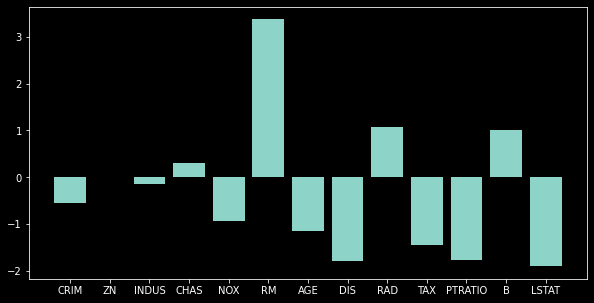

In [12]:
# Split the dataset
X = pd.DataFrame(boston.drop("MEDV", axis=1))
y = boston["MEDV"]

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale all the values 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression().fit(X_train, y_train)
importance = regressor.coef_

for idx, val in enumerate(importance):
    col_name = X.iloc[:, idx].name
    print("Feature: {}, Score: {:.5f}".format(col_name, val))

plt.figure(figsize=(10, 5))
_ = plt.bar([X.iloc[:, x].name for x in range(len(importance))], importance)
plt.savefig("feature_importance")

It seems that features `RM` and `RAD` are the 2 of the most important features here. It makes sense because `RM` pertains to the average rooms per house/apartment and `RAD` pertains to accessibility to urban cities which is the most logical reason for price hikes.

Let's use this in the real action.

#### EDA

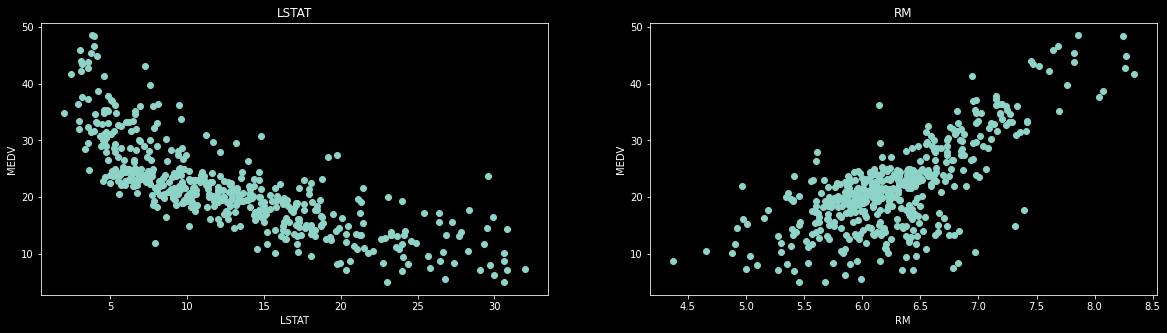

In [13]:
plt.figure(figsize=(20, 5))

features = ["LSTAT", "RM"]
target = boston["MEDV"]

for i, col in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker="o")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("MEDV")

We can see that `LSTAT` is negatively correlated with `MEDV` while `RM` is positively correlated. Although both have a slight curve, this is useful in identifying what ML model we will use later on.

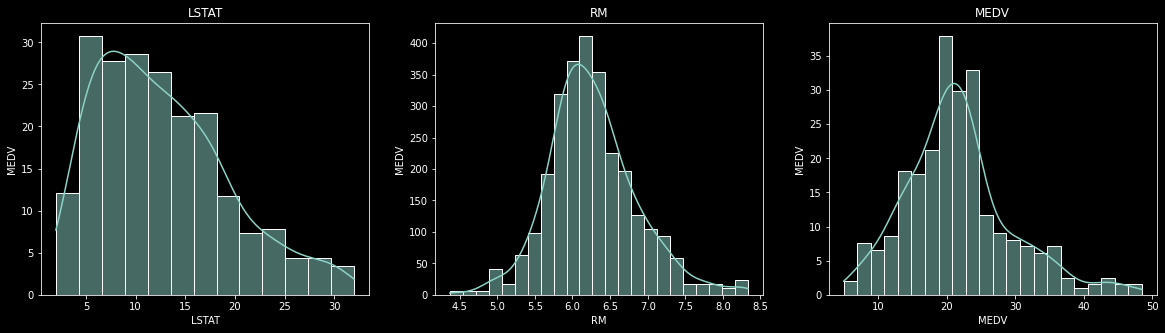

In [14]:
plt.subplots(figsize=(20, 5))
features = ["LSTAT", "RM", "MEDV"]
for i, col in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    x = boston[col]
    y = target
    _ = sns.histplot(data=boston, x=x, stat="frequency", kde=True)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("MEDV")


We can see here in the last two cells that our data is capped at 50. But those are outliers lingering on the left of our chart. This normal distribution with outliers on the left will be useful in removing outliers later in these notebook.

### Linear Regression

#### Data Splitting

In [15]:
X = boston[["RM", "LSTAT"]].values.reshape(-1, 2)
Y = boston["MEDV"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

#### Feature Scaling

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Model Traning

In [18]:
regressor = LinearRegression().fit(X_train, y_train)

#### Scoring Metrics

In [19]:
# Train Data
y_train_pred = regressor.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print("# ------------TRAIN DATA---------------- #")
print(f"RMSE Score: {rmse}")
print(f"R2 Score: {r2_train}\n")

y_test_pred = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("# ------------TEST DATA---------------- #")
print(f"RMSE Score: {rmse}")
print(f"R2 Score: {r2_test}")

# ------------TRAIN DATA---------------- #
RMSE Score: 4.224353425321058
R2 Score: 0.696737386028337

# ------------TEST DATA---------------- #
RMSE Score: 4.244607077372462
R2 Score: 0.7230765083582817


#### Compare Actual to Predicted Values

In [20]:
comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_test_pred}).reset_index(drop=True)
comparison.head()

,Actual,Predicted
0,10.4,22.87
1,17.8,17.72
2,25.1,25.57
3,24.0,21.84
4,20.5,17.01


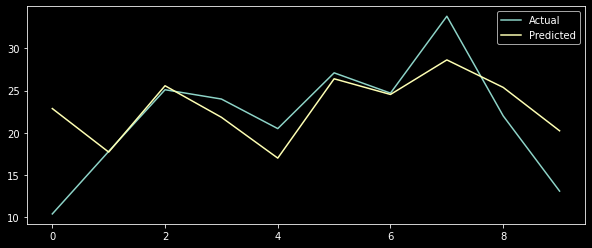

In [21]:
_ = comparison.head(10).plot(kind="line", figsize=(10,4))

#### Model Visualization

In [22]:
# 3 Dimensional Variables
x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(3, 9, 30)      # range of RM values
y_pred = np.linspace(1, 38, 30)  # range of LSTAT values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

In [23]:
predicted = regressor.predict(sc.transform(model_viz))

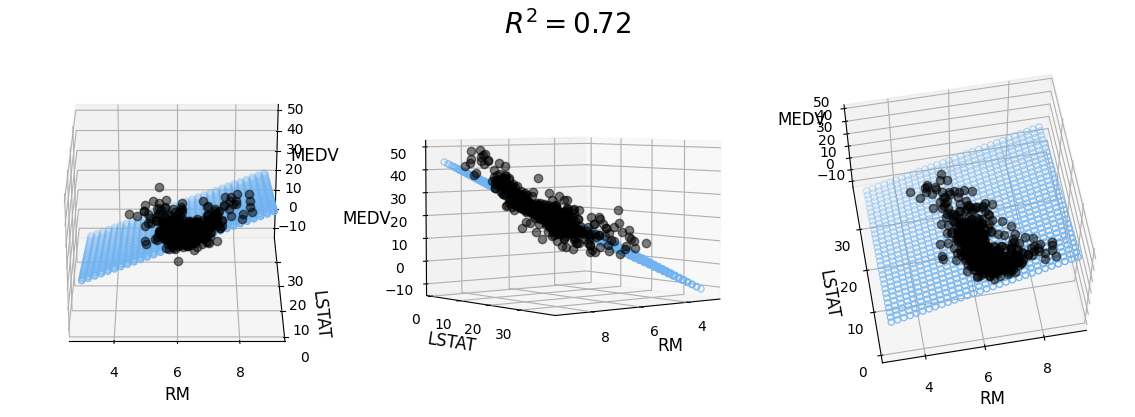

In [24]:
plt.style.use("default")
fig = plt.figure(figsize=(12, 4))


ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color="k", zorder=15, linestyle="none", marker="o", alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor="#70b3f0")
    ax.set_xlabel("RM", fontsize=12)
    ax.set_ylabel("LSTAT", fontsize=12)
    ax.set_zlabel("MEDV", fontsize=12)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")

ax1.view_init(elev=28, azim=-90)
ax2.view_init(elev=4, azim=51)
ax3.view_init(elev=60, azim=-100)

fig.suptitle("$R^2 = %.2f$" % r2_test, fontsize=20)
fig.tight_layout()
fig.savefig("3D_lin_reg.png")

#### Generating 3D Model Every Angel

In [ ]:
for ii in np.arange(0, 360, 1):
    ax2.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)

### Polynomial Regression

In [25]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)

LinearRegression()

#### Predicting on Train Data

In [26]:
poly_train = lin_reg.predict(X_poly)

#### Predicting on Test Data

In [27]:
poly_test = lin_reg.predict(poly_reg.fit_transform(X_test))

#### Scoring Metrics

In [28]:
# Train Data
r2_poly_train = r2_score(y_train, poly_train)
poly_train_rmse = np.sqrt(mean_squared_error(y_train, poly_train))

print("# ------------TRAIN DATA---------------- #")
print(f"RMSE Score: {poly_train_rmse}")
print(f"R2 Score: {r2_poly_train}\n")

r2_poly_test = r2_score(y_test, poly_test)
poly_test_rmse = np.sqrt(mean_squared_error(y_test, poly_test))

print("# ------------TEST DATA---------------- #")
print(f"RMSE Score: {poly_test_rmse}")
print(f"R2 Score: {r2_poly_test}\n")

# ------------TRAIN DATA---------------- #
RMSE Score: 3.517812478312811
R2 Score: 0.7896978306051383

# ------------TEST DATA---------------- #
RMSE Score: 3.3821859786927844
R2 Score: 0.8241753422613014



#### Compare Actual to Predicted Values

In [29]:
poly_comparison = pd.DataFrame({"Actual": y_test, "Predicted": poly_test}).reset_index(drop=True)
poly_comparison.head()

,Actual,Predicted
0,10.4,19.57
1,17.8,16.53
2,25.1,25.02
3,24.0,21.07
4,20.5,16.62


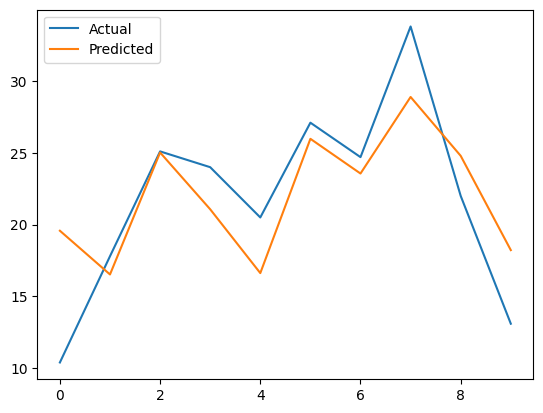

In [30]:
_ = poly_comparison.head(10).plot(kind="line")

#### Model Visualization

In [31]:
# x = X[:, 0]
# y = X[:, 1]
# z = Y

# x_pred = np.linspace(3, 9, 30)      # range of RM values
# y_pred = np.linspace(1, 38, 30)  # range of LSTAT values
# xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
# model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

In [32]:
poly_predicted = lin_reg.predict(poly_reg.fit_transform(sc.transform(model_viz)))

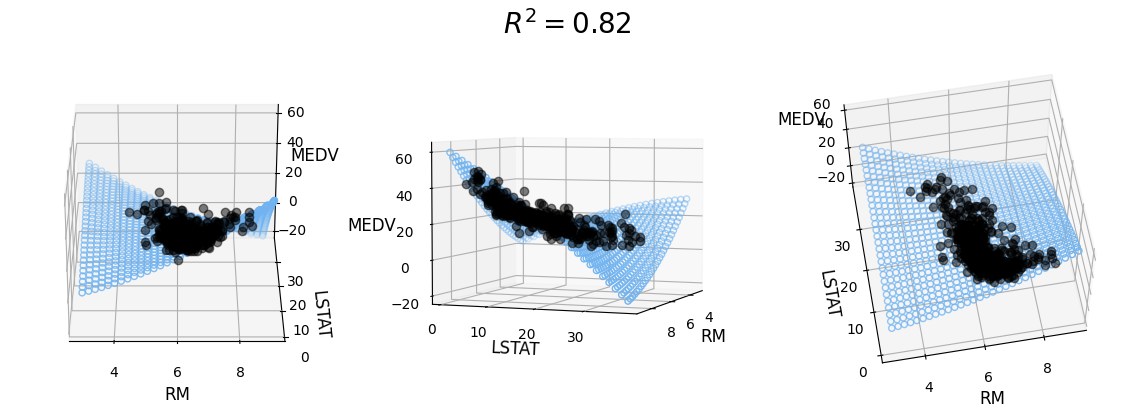

In [33]:
plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color="k", zorder=15, linestyle="none", marker="o", alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), poly_predicted, facecolor=(0,0,0,0), s=20, edgecolor="#70b3f0")
    ax.set_xlabel("RM", fontsize=12)
    ax.set_ylabel("LSTAT", fontsize=12)
    ax.set_zlabel("MEDV", fontsize=12)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")


ax1.view_init(elev=28, azim=-90)
ax2.view_init(elev=4, azim=21)
ax3.view_init(elev=60, azim=-100)
fig.suptitle("$R^2 = %.2f$" % r2_poly_test, fontsize=20)

fig.tight_layout()
fig.savefig("3D_poly.png")

#### Generating 3D Model Every Angel

In [34]:
for ii in np.arange(0, 360, 1):
    ax2.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)

### SVR

In [34]:
svr = SVR(kernel='rbf', gamma=0.028571428571428574, epsilon=0.06122448979591837, C=63).fit(X_train, y_train)

#### Predicting on Train Data

In [35]:
svr_train = svr.predict(X_train)

#### Predicting on Test Data

In [36]:
svr_test = svr.predict(X_test)

#### Scoring Metrics

In [37]:
r2_train_svr = r2_score(y_train, svr_train)
rmse_train_svr = np.sqrt(mean_squared_error(y_train, svr_train))

print("# ------------TRAIN DATA---------------- #")
print(f"RMSE Score: {rmse_train_svr}")
print(f"R2 Score: {r2_train_svr}\n")

r2_test_svr = r2_score(y_test, svr_test)
rmse_test_svr = np.sqrt(mean_squared_error(y_test, svr_test))

print("# ------------TEST DATA---------------- #")
print(f"RMSE Score: {rmse_test_svr}")
print(f"R2 Score: {r2_test_svr}\n")

# ------------TRAIN DATA---------------- #
RMSE Score: 3.4509069775668526
R2 Score: 0.7976212599435457

# ------------TEST DATA---------------- #
RMSE Score: 3.2713587846321937
R2 Score: 0.8355093689774972



#### Compare Actual to Predicted Values

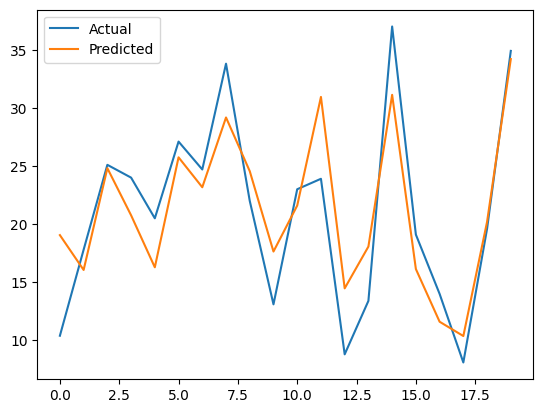

In [38]:
svr_compare = pd.DataFrame({"Actual" : y_test, "Predicted" : svr_test}).reset_index(drop=True)
_ = svr_compare.head(20).plot(kind="line")

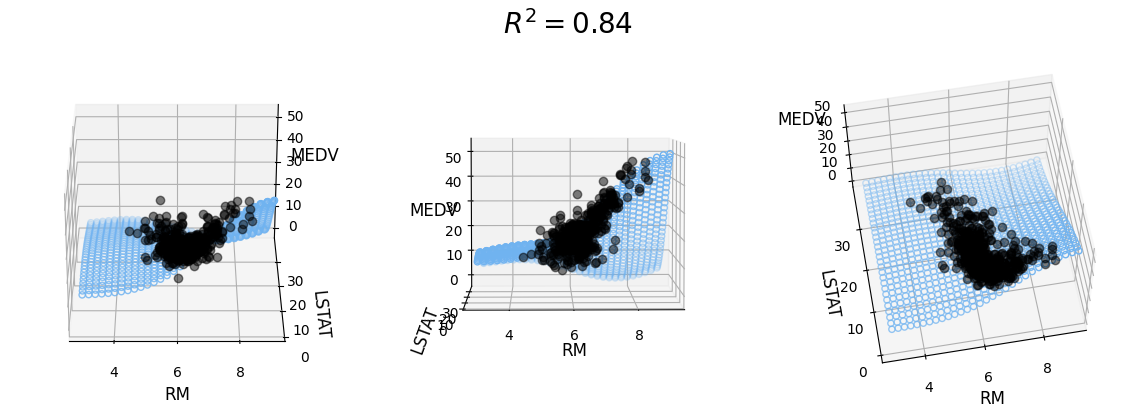

In [39]:
svr_predicted = svr.predict(sc.transform(model_viz))

plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color="k", zorder=15, linestyle="none", marker="o", alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), svr_predicted, facecolor=(0,0,0,0), s=20, edgecolor="#70b3f0")
    ax.set_xlabel("RM", fontsize=12)
    ax.set_ylabel("LSTAT", fontsize=12)
    ax.set_zlabel("MEDV", fontsize=12)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")


ax1.view_init(elev=28, azim=-90)
ax2.view_init(elev=4, azim=-91)
ax3.view_init(elev=60, azim=-100)
fig.suptitle("$R^2 = %.2f$" % r2_test_svr, fontsize=20)

fig.tight_layout()
fig.savefig("3D_svr.png")

#### Hyperparameter Tuning

In [41]:
# Hyper Parameter Optimization
parameters = {'C': range(1, 100), 
              'kernel': ["poly", "rbf", "sigmoid"],
              "epsilon": np.linspace(0, 0.1, 50),
              "gamma": np.linspace(0, 0.1, 50)
             }

random_search = RandomizedSearchCV(estimator = svr,
                                   param_distributions = parameters,
                                   cv = 10,
                                   scoring = "r2",
                                   n_jobs = -1,
                                   verbose = 2
                                  )
random_search.fit(X, y)
best_accuracy = random_search.best_score_
best_params = random_search.best_params_
print("Best Accuracy: {:.2f}".format(best_accuracy*100))
print("Best Parameters:", best_params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Accuracy: 99.98
Best Parameters: {'kernel': 'rbf', 'gamma': 0.028571428571428574, 'epsilon': 0.06122448979591837, 'C': 63}


#### Generating 3D Model Every Angel

In [40]:
for ii in np.arange(0, 360, 1):
    ax2.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)